#데이터 
https://github.com/rikdz/GraphWriter/tree/master

In [ ]:
#unprocessed
{
    "title": "Hierarchical Semantic Classification : Word Sense Disambiguation with World Knowledge .",
    "entities": [
      "task-specific and background data",
      "lexical semantic classification problems",
      "word sense disambiguation task",
      "hierarchical learning architecture",
      "task-specific training data",
      "background data",
      "learning architecture"
    ],
    "types": "<material> <task> <task> <method> <material> <material> <method>",
    "relations": [
      "learning architecture -- USED-FOR -- lexical semantic classification problems"
    ],
    "abstract": "we present a <method_6> for <task_1> that supplements <material_4> with <material_5> encoding general '' world knowledge '' . the <method_6> compiles knowledge contained in a dictionary-ontology into additional training data , and integrates <material_0> through a novel <method_3> . experiments on a <task_2> provide empirical evidence that this '' <method_3> '' outperforms a state-of-the-art standard '' flat '' one .",
    "abstract_og":" we present a learning architecture for lexical semantic classification problems that supplements task-specific training data with background data encoding general '' world knowledge '' . the learning architecture compiles knowledge contained in a dictionary-ontology into additional training data , and integrates task-specific and background data through a novel hierarchical learning architecture . experiments on a word sense disambiguation task provide empirical evidence that this '' hierarchical learning architecture '' outperforms a state-of-the-art standard '' flat '' one ."
  },

In [ ]:
#relation.vocab
USED-FOR
CONJUNCTION
FEATURE-OF
PART-OF
COMPARE
EVALUATE-FOR
HYPONYM-OF

In [ ]:
#processed
Hierarchical Semantic Classification : Word Sense Disambiguation with World Knowledge .	task-specific and background data ; lexical semantic classification problems ; 
word sense disambiguation task ; hierarchical learning architecture ; task-specific training data ; background data ; learning architecture	
<material> <task> <task> <method> <material> <material> <method>	6 0 1
	we present a <method_6> for <task_1> that supplements <material_4> with <material_5> encoding general '' world knowledge '' .
   the <method_6> compiles knowledge contained in a dictionary-ontology into additional training data , and integrates <material_0> through a novel <method_3> . 
   experiments on a <task_2> provide empirical evidence that this '' <method_3> '' outperforms a state-of-the-art standard '' flat '' one .
   	6 1 4 5 8 7 -1 0 3 7 -1 2 7 -1'


#트리플이란?
- 그래프 데이터를 표현 
- 각 요소는 공백으로 표현 
- 첫번째 요소는 출발 노드(엔티티), 두번째 요소는 관계(엣지), 세번째 요소는 도착노드 (엔티티)를 나타낸다. 

ex) 1 0 2; 2 1 3; 3 0 4

첫번째 트리플은 출발 노드가 1, 관계가 0, 도착노드가 2인 트리플을 나타냄. 
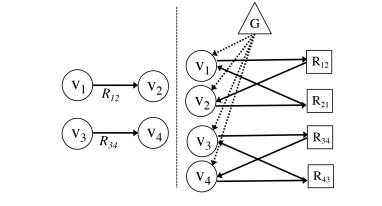

In [ ]:
 def mkGraphs(self,r,ent):
    #triples을 입력으로 받아 엔터티 리스트와 인접 행렬(adjacency matrix) 및 관계 행렬(relation matrix)
    #로 변환하는 기능을 수행
    #r이 트리플을 나타내는 문자열 
    #ent는 엔티티의 개수를 나타냄
    pieces = r.strip().split(';')
    #문자열 r을 세미콜론을 기준으로 분리하여 pieces리스트에 저장한다. 
    x = [[int(y) for y in z.strip().split()] for z in pieces]
    #각 리스트 요소에서 공백을 기준으로 분리하여 정수형으로 변환 > 트리플의 요소들을 숫자로 추출
    rel = [2]
    adjsize = ent+1+(2*len(x)) 
    adj = torch.zeros(adjsize,adjsize)#크기가 adjsize인 0으로 초기화된 토치텐서 생성. 이는 인접행렬을 나타냄 
    for i in range(ent): #엔티티의 개수만큼 반복 
      #adj[i,0]=1
      adj[ent+1,i]=1 #엔티티와 global root node사이의 연결을 나타내는 인접행렬 요소를 1로 설정 
      #global root node와 i 번째 엔티티 사이의 연결을 나타내는 것. 
    for i in range(adjsize):
      adj[i,i]=1 #인접 행렬의 대각선 요소들을 1로 설정하여 자기 자신과의 연결을 나타냄   
    for y in x:
      rel.extend([y[1]+3,y[1]+3+self.REL.size])# rel리스트에 트리플의 관계를 추가한다. 
      #트리플의 두번째 요소 y[1]에 3을 더하고, self.REL.size를 더하여 관계를 인덱스화
      a = y[0] #트리플의 첫번째 요소를 a
      b = y[2] #세번째 요소를 b로 할당
      c = ent+len(rel)-2
      d = ent+len(rel)-1
      adj[a,c] = 1 
      adj[c,b] = 1
      adj[b,d] = 1 
      adj[d,a] = 1
    rel = torch.LongTensor(rel)
    return (adj,rel) #생성된 인접행렬과 관계행렬을 반환. 트리플을 엔티티 리스트와 함께 표현하는 구조인 그래프를 나타냄. 

#인코더 

In [ ]:
import torch
import math
from torch import nn
from torch.nn import functional as F
from models.graphAttn import GAT #구현된 것 import 
from allennlp.modules.seq2seq_encoders.stacked_self_attention import StackedSelfAttentionEncoder
from models.attention import MultiHeadAttention #구현된 것 import 


def gelu(x): #활성화함수로 gelu사용 
  return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Block(nn.Module):
  def __init__(self,args):
    super().__init__()
    self.attn = MultiHeadAttention(args.hsz,args.hsz,args.hsz,h=4,dropout_p=args.drop) #헤드가 4인 멀티헤드어텐션 
    self.l1 = nn.Linear(args.hsz,args.hsz*4) #선형변환 
    self.l2 = nn.Linear(args.hsz*4,args.hsz) #선형변환 
    self.ln_1 = nn.LayerNorm(args.hsz)
    self.ln_2 = nn.LayerNorm(args.hsz)
    self.drop = nn.Dropout(args.drop)
    self.act = gelu

  def forward(self,q,k,m):
    q = self.attn(q,k,mask=m).squeeze(1) #q,k,m에 대해 multiHeadAttention을 수행 , 크기가 1인 차원을 제거
    t = self.ln_1(q) #레이어 정규화 
    q = self.drop(self.l2(self.act(self.l1(t)))) #선형변환> glue > 선형변환> drop
    q = self.ln_1(q+t) #t와 q를 합한 것을 레이어 정규화 
    return q

class graph_encode(nn.Module):
  def __init__(self,args):
    super().__init__()
    self.renc = nn.Embedding(args.rtoks,args.hsz)
    nn.init.xavier_normal_(self.renc.weight)
    #self.gat = StackedSelfAttentionEncoder(args.hsz,args.hsz,args.hsz,args.hsz,args.prop,args.heads,use_positional_encoding=False)

    self.gat = nn.ModuleList([MultiHeadAttention(args.hsz,args.hsz,args.hsz,h=4,dropout_p=args.drop) for _ in range(args.prop)])
    self.gat = nn.ModuleList([Block(args) for _ in range(args.prop)])
    self.prop = args.prop

  def pad(self,tensor,length):
    return torch.cat([tensor, tensor.new(length - tensor.size(0), *tensor.size()[1:]).fill_(0)])

  def forward(self,adjs,rels,ents):
    #adjs: 그래프의 인접 행렬들을 나타내는 리스트
    #rels: 관계에 대한 정보를 나타내는 리스트 
    #ents: 엔터티에 대한 정보를 나타내는 튜플 --> 엔터티 벡터와 엔터티 길이를 담은 튜플
    vents,entlens = ents
    vents = torch.tensor(vents,requires_grad=False)
    vrels = [self.renc(x) for x in rels] #관계 정보에 대한 임베딩 수행 
    gents = [] #엔터티 벡터 
    grels = [] #관계 벡터 
    glob = [] #그래프 전역 벡터  를 저장할 변수,, 리스트초기화 
    for i,adj in enumerate(adjs):
      vgraph = torch.cat((vents[i][:entlens[i]],vrels[i]),0) #그래프에 대한 엔터티 벡터와 관계벡터를 결합하여 vgraph생성 
      N = vgraph.size(0)
      mask = (adj == 0).unsqueeze(1)
      for j in range(self.prop): #self.prop에 지정된 횟수만큼 반복하여 그래프 인코딩  
        ngraph = vgraph.repeat(N,1).view(N,N,-1)
        vgraph = self.gat[j](vgraph.unsqueeze(1),ngraph,mask) 
        vgraph = F.layer_norm(vgraph,vgraph.size()[1:])
      gent = vgraph[:entlens[i],:] #엔터티 벡터 
      grel = vgraph[entlens[i]+1:,:] #관계벡터 
      glob.append(vgraph[entlens[i]]) #그래프 전역벡터 
      gents.append(gent)
      grels.append(grel)
    #인코딩된 엔터티 벡터 gents와 관계 벡터 grels의 길이를 맞추기 위해 패딩을 수행 
    elens = [x.size(0) for x in gents] #각각길이 정보 저장 
    gents = [self.pad(x,max(elens)) for x in gents]
    gents = torch.stack(gents,0) #길이만큼의 패딩된 텐서를 생성 
    elens = torch.LongTensor(elens)
    emask = torch.arange(0,gents.size(1)).unsqueeze(0).repeat(gents.size(0),1).long()
    emask = (emask <= elens.unsqueeze(1)).cuda()
    rlens = [x.size(0) for x in grels]
    grels = [self.pad(x,max(rlens)) for x in grels]
    grels = torch.stack(grels,0)
    rlens = torch.LongTensor(rlens)
    rmask = torch.arange(0,grels.size(1)).unsqueeze(0).repeat(grels.size(0),1).long()
    rmask = (rmask <= rlens.unsqueeze(1)).cuda()
    glob = torch.stack(glob,0)
    return (gents,emask),glob,(grels,rmask) #인코딩 결과인 (gents,emask)튜플과 전역벡터 glob,관계 벡터 인코딩 결과인 (grels,rmask)튜플을 반환 

#graphattentionlayer

In [ ]:
#GAT의 한 레이어를 구현하여 입력 특성과 인접 행렬을 기반으로 출력 특성을 계산함

class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        #학습가능한 파라미터 w는 입력 특성을 출력특성으로 변환하는 가중치 행렬 
        nn.init.xavier_uniform_(self.W.data, gain=1.414) #가중치 초기화 방법. 각 가중치를 균등 분포에서 무작위로 초기화하는 방법 
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        #어텐션 가중치를 계산하기 위한 가중치 벡터 
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = torch.mm(input, self.W) #입력을 가중치 행렬W를 통해서 선형 변환한다. 
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        #입력 h를 사용하여 각 노드 쌍의 어텐션 계수를 계산 
        e = self.leakyrelu(torc 
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec) #계산된 어텐션계수에 인접행렬 adj를 적용하여 어텐션 메커니즘을 적용한다. 
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training) #정규화, 드롭아웃
        h_prime = torch.matmul(attention, h) # 정규화된 어텐션 계수를 사용하여 가중 평균을 계산하여 출력특성을 얻는다. 

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'
